In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA


Base de datos de la temperatura de la Tierra por Paises y Global. Base de datos obtenida de Kaggle (https://www.kaggle.com/sachinsarkar/climate-change-global-temperature-data)

In [2]:
# Leemos la tabla con la que vamos a trabajar y renombramos las columnas

file_path="tablas_ini/Kaggledata_GlobalLandTemperaturesByCountry.csv"
data_GobalTemp_Country=pd.read_csv(file_path,converters={"dt":pd.to_datetime})
data_GobalTemp_Country.rename(columns={"dt": "fecha","AverageTemperature": "Temp. promedio", 
                     "AverageTemperatureUncertainty":"Error","Country":"Pais"},inplace=True)

data_GobalTemp_Country=data_GobalTemp_Country.set_index("fecha")

In [3]:
# Listamos todos los paises de los que hay medidas de temperatura
lista_paises =pd.unique(data_GobalTemp_Country["Pais"]).tolist()
print(lista_paises)

['Åland', 'Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Baker Island', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bonaire, Saint Eustatius And Saba', 'Bosnia And Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', "Côte D'Ivoire", 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Colombia', 'Comoros', 'Congo (Democratic Republic Of The)', 'Congo', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark (Europe)', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Europe', 'Falkland Islan

In [41]:
# Función para selecionar los datos del Pais que nos interesa y renombrar las columnas con el nombre del pais
def crear_lista(df,pais):
    df=df.loc[((df['Pais'] == pais))]
    df.drop("Pais",axis=1,inplace=True)
    df.rename(columns={"Temp. promedio": "Temp. "+str(pais),"Error": "Error "+str(pais)},inplace=True)
    return df

In [65]:
# Selecionamos los datos de los continentes y los juntamos todos en un único DataFrame
data_Asia=crear_lista(data_GobalTemp_Country,"Asia")
data_Europe=crear_lista(data_GobalTemp_Country,"Europe")
data_Africa=crear_lista(data_GobalTemp_Country,"Africa")
data_North_America=crear_lista(data_GobalTemp_Country,"North America")
data_Oceania=crear_lista(data_GobalTemp_Country,"Oceania")
data_South_America=crear_lista(data_GobalTemp_Country,"South America")


data = pd.concat([data_Asia, data_Europe,data_Africa,data_North_America,
                 data_Oceania,data_South_America], axis=1)

In [66]:
# Nos quedamos solo con los datos desde 1855, antes no hay datos de todos los contienentes y de los que hay,
# algunos no son muy buenos
data = data[~(data.index < '1860-01-01')]

In [67]:
# Extraemos de la fecha por un lado los meses y por otro los años, guardamos la información de dos nuevas columnas
data_month=data.reset_index()
data_month['month'] = data_month['fecha'].dt.month

data_month['year'] = data_month['fecha'].dt.year

In [68]:
# Función para calcular la temperatura máxima, mínima y promedio de cada año 
def cal_sts(pais):
    data_sts["max. "+str(pais)]=data_month.groupby(['year'], sort=False)['Temp. '+str(pais)].max()
    data_sts["min. "+str(pais)]=data_month.groupby(['year'], sort=False)['Temp. '+str(pais)].min()
    data_sts["avg. "+str(pais)]=data_month.groupby(['year'], sort=False)['Temp. '+str(pais)].mean()
    return data_sts

In [69]:
# Creamos una nueva tabla con los datos de temp. máxima, mínima y promedio por año para cada Contiente

data_sts=pd.DataFrame(columns=["max. Asia","min. Asia","avg. Asia",
                               "max. Europe","min. Europe","avg. Europe",
                               "max. Africa","min. Africa","avg. Africa",
                               "max. North America","min. North America","avg. North America",
                               "max. Oceania","min. Oceania","avg. Oceania",
                               "max. South America","min. South America","avg. South America"])

data_sts=cal_sts("Asia")
data_sts=cal_sts("Europe")
data_sts=cal_sts("Africa")
data_sts=cal_sts("North America")
data_sts=cal_sts("Oceania")
data_sts=cal_sts("South America")


In [70]:
# Calculamos los promedios móvil de la temp. mínima, máxima y promédio anual que acabamos de calcular. 
# También calculamos los promedios móviles de la temperatura medida mensualmente (datos originales) 
vent=12

data_sts_temp=data_sts.fillna(0)
data_sts_mov_avg=data_sts_temp.rolling(vent).mean()

data_temp=data.fillna(0)
data_mov_avg=data_temp.rolling(vent).mean()
data_mov_std=data_temp.rolling(vent).std()

In [71]:
# Convertimos a formato fecha el indice de la tabla de temp. max, min, y avg.
data_sts_mov_avg.index = pd.to_datetime(data_sts_mov_avg.index,format='%Y')

data_sts.index = pd.to_datetime(data_sts.index,format='%Y')

#### Estadistica de los datos

In [72]:
# estadistica de los datos
data.describe()

Temp. Asia   Error Asia  Temp. Europe  Error Europe  Temp. Africa  \
count  1844.000000  1844.000000   1844.000000   1844.000000   1843.000000   
mean      7.472893     0.325223      7.984531      0.350548     24.089445   
std      10.193551     0.249781      7.197742      0.287119      1.768259   
min     -10.707000     0.055000     -7.549000      0.076000     19.523000   
25%      -1.897750     0.158000      1.261500      0.185000     22.747000   
50%       8.148500     0.237000      7.748000      0.249000     24.829000   
75%      18.151250     0.389000     14.930750      0.400250     25.421500   
max      22.635000     1.612000     20.582000      2.968000     27.126000   

       Error Africa  Temp. North America  Error North America  Temp. Oceania  \
count   1843.000000          1845.000000          1845.000000    1844.000000   
mean       0.378757             2.241831             0.435121      21.485715   
std        0.283084             9.992193             0.346303       4.563419   
min        0.077000           -15.647000             0.084000      12.943000   
25%        0.181000            -7.367000             0.187000      17.190500   
50%        0.259000             2.323000             0.285000      21.981000   
75%        0.491500            12.429000             0.581000      25.788750   
max        1.798000            17.944000             2.291000      29.154000   

       Error Oceania  Temp. South America  Error South America  
count    1844.000000          1844.000000          1844.000000  
mean        0.427418            21.852991             0.400069  
std         0.374000             1.572667             0.290245  
min         0.078000            18.055000             0.066000  
25%         0.185000            20.558000             0.186000  
50%         0.263000            22.116000             0.275000  
75%         0.508000            23.180250             0.578250  
max         2.295000            24.820000             2.278000

array([[<AxesSubplot:title={'center':'Temp. Asia'}>,
        <AxesSubplot:title={'center':'Error Asia'}>],
       [<AxesSubplot:title={'center':'Temp. Europe'}>,
        <AxesSubplot:title={'center':'Error Europe'}>],
       [<AxesSubplot:title={'center':'Temp. Africa'}>,
        <AxesSubplot:title={'center':'Error Africa'}>],
       [<AxesSubplot:title={'center':'Temp. North America'}>,
        <AxesSubplot:title={'center':'Error North America'}>],
       [<AxesSubplot:title={'center':'Temp. Oceania'}>,
        <AxesSubplot:title={'center':'Error Oceania'}>],
       [<AxesSubplot:title={'center':'Temp. South America'}>,
        <AxesSubplot:title={'center':'Error South America'}>]],
      dtype=object)

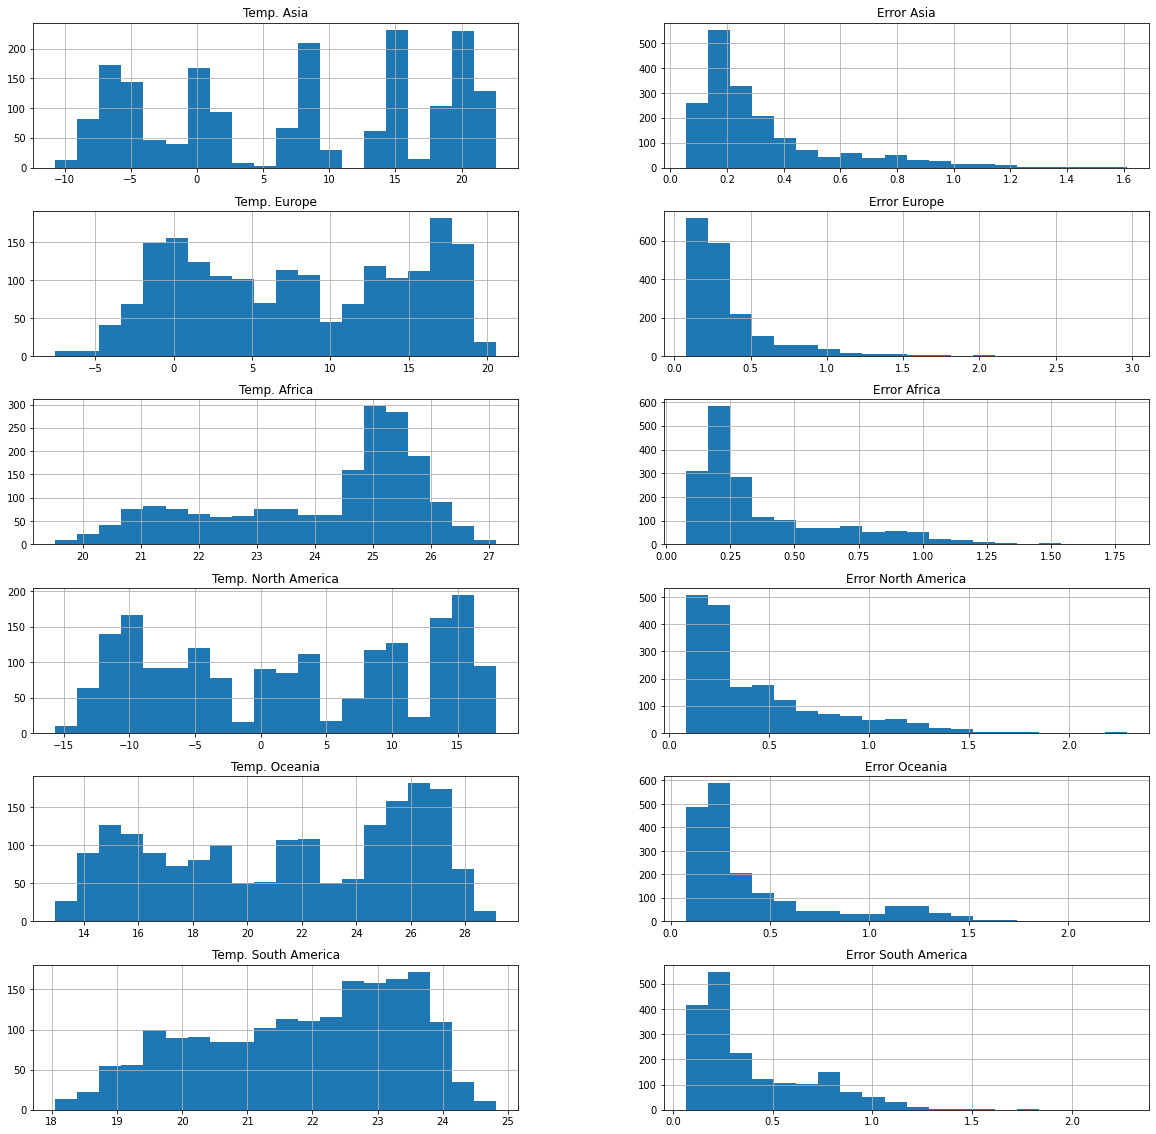

In [73]:
# Histograma de los datos
data.hist(bins=20, figsize=(20, 20), layout=(6, 2))

#### Distribución de los datos por meses

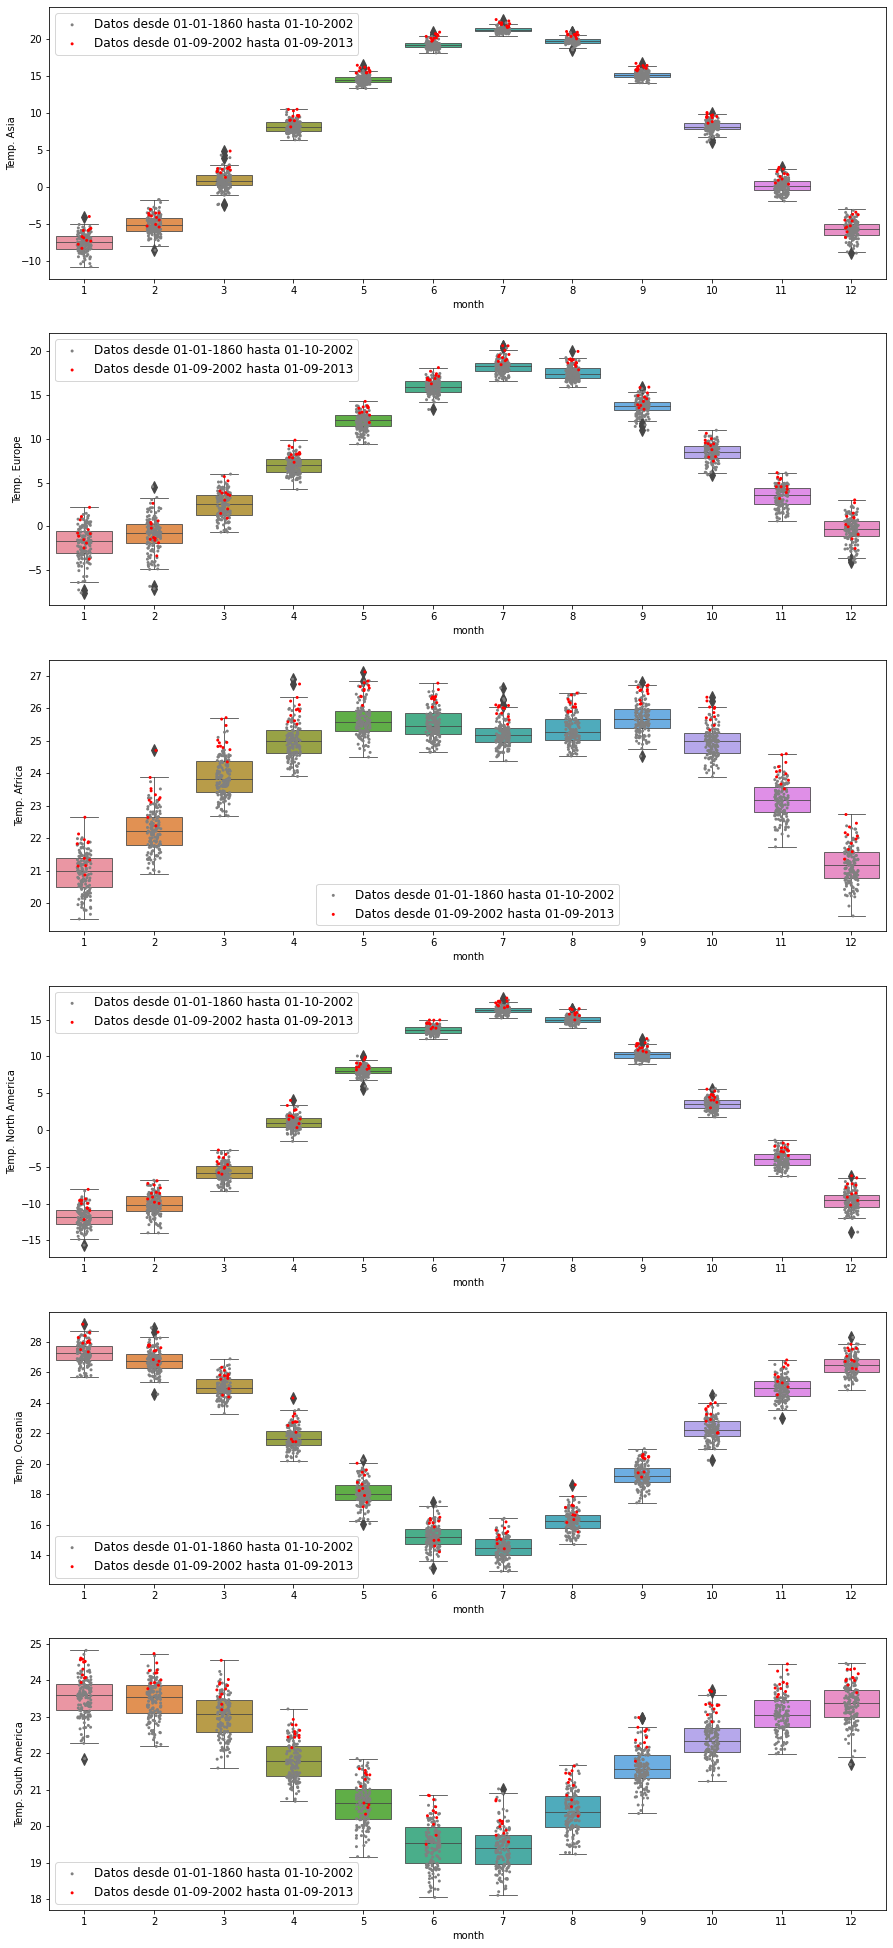

In [74]:
# Boxplot de los datos de cada continente para cada mes + scatterplot de las temperaturas medidas en cada mes
# Hemos representado las temperaturas de los últimos 11 años en otro color para ver si están fuera de la normalidad

fig, ax = plt.subplots(nrows=6, ncols=1,figsize=(15,35),sharex=False)

a=["Temp. Asia","Temp. Europe","Temp. Africa","Temp. North America","Temp. Oceania","Temp. South America"]
pos=['upper left','upper left',"lower center",'upper left',"lower left","lower left"]

for i in range(len(a)):
    sns.stripplot(x=data_month["month"][:-132], y=data_month[a[i]][:-132],color="grey",ax=ax[i]
                  ,size=3,jitter=True,label="Datos desde "+str(data_month["fecha"].iloc[0].strftime("%d-%m-%Y"))+
                  " hasta "+str(data_month["fecha"].iloc[-132].strftime("%d-%m-%Y")))
    sns.stripplot(x=data_month["month"][-133:], y=data_month[a[i]][-133:],color="red",ax=ax[i]
                  ,size=3,jitter=True,label="Datos desde "+str(data_month["fecha"].iloc[-133].strftime("%d-%m-%Y"))+
                  " hasta "+str(data_month["fecha"].iloc[-1].strftime("%d-%m-%Y")))
    sns.boxplot(x=data_month["month"], y=data_month[a[i]],ax=ax[i],fliersize=8,linewidth=0.8)
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend((handles[i] for i in [1,13]), (labels[i] for i in [1,13]),loc=pos[i],fontsize=12)

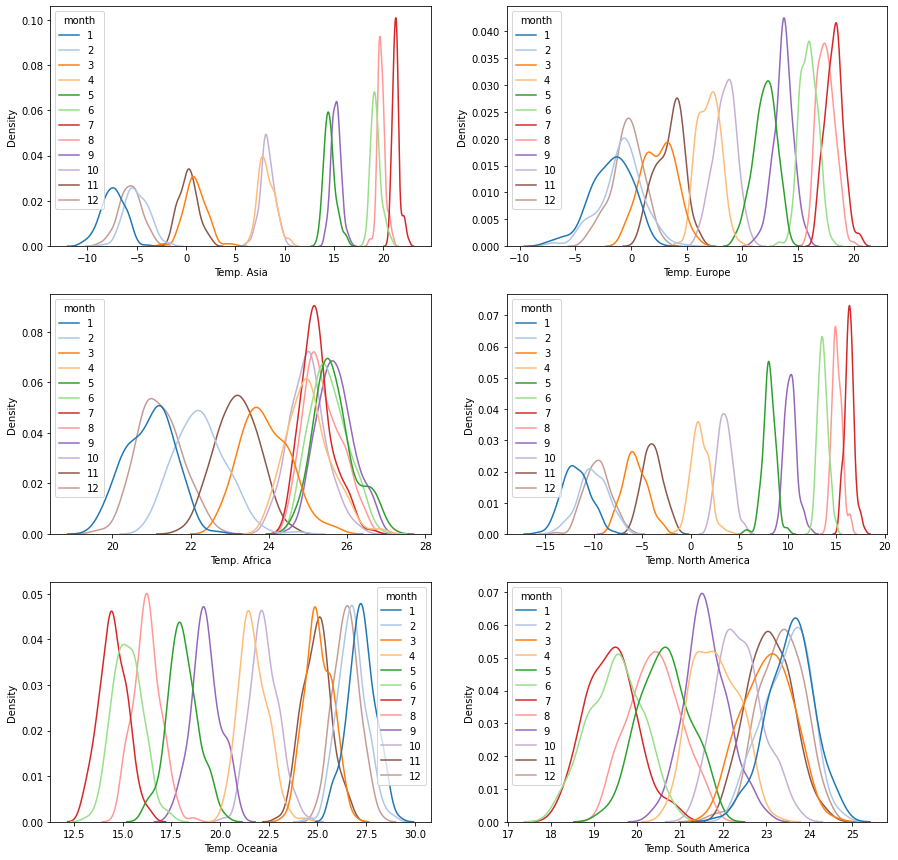

In [75]:
# Representación de la distrubución (KDE) de la temperatura medida cada mes para los diferentes contienentes 
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

a=["Temp. Asia","Temp. Europe","Temp. Africa","Temp. North America","Temp. Oceania","Temp. South America"]

for i in range(len(a)):
    ax = fig.add_subplot(3, 2, i+1)
    sns.kdeplot(data=data_month,x=a[i],hue="month",palette='tab20',ax=ax)


#### Representación de los datos

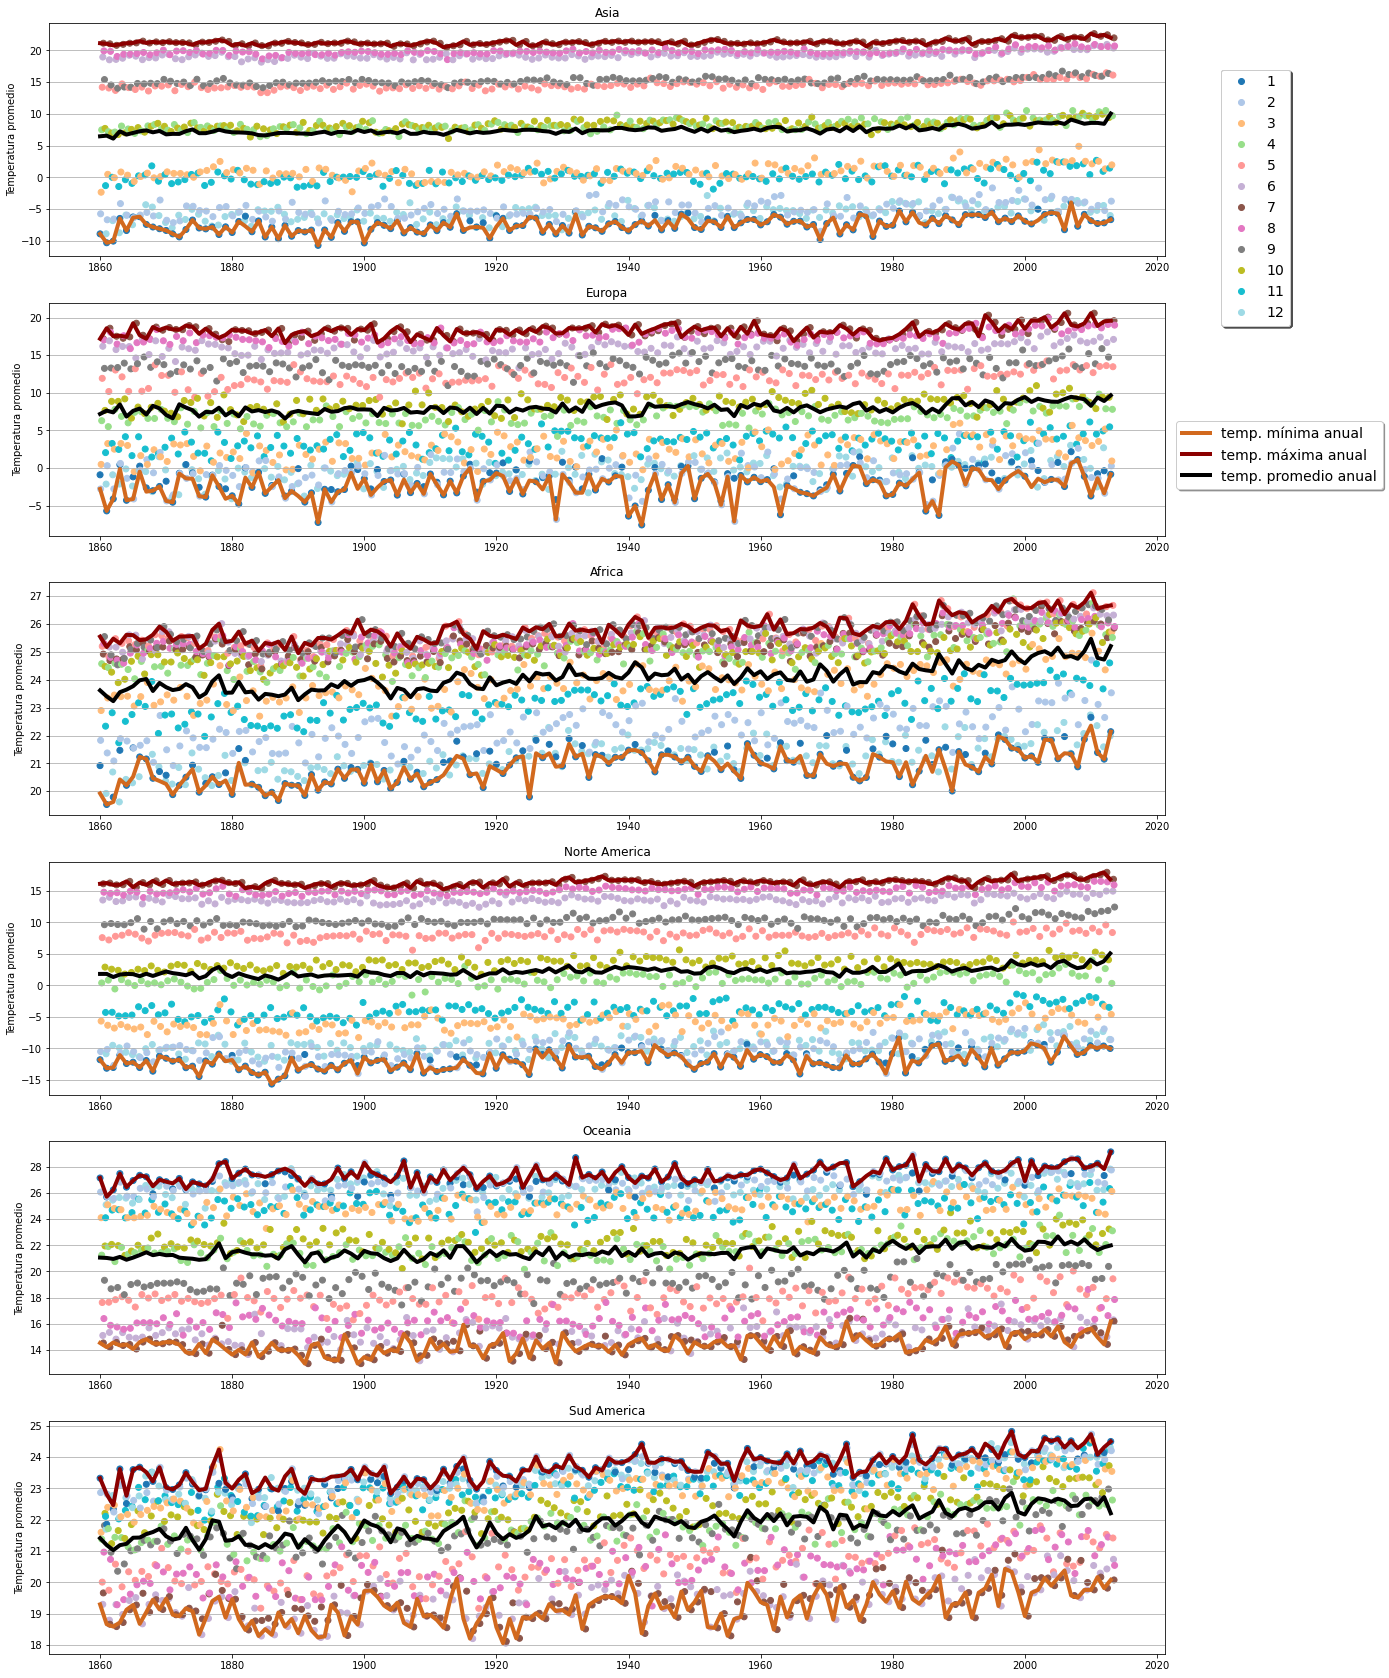

In [76]:
# Representamos todas las temperaturas medidas mensualmente junto con el promedio móvil de la temperaturas
# mínimas, máximas y promedios para cada Continente

fig, ax = plt.subplots(nrows=6, ncols=1,figsize=(20,30),sharex=False)

a=["Temp. Asia","Temp. Europe","Temp. Africa","Temp. North America","Temp. Oceania","Temp. South America"]
titulo=["Asia","Europa","Africa","Norte America","Oceania","Sud America"]
b=["Asia","Europe","Africa","North America","Oceania","South America"]

plot_lines = []

for i in range(len(a)):
    scatter = ax[i].scatter(data_month["fecha"][:],data_month[a[i]][:],c=data_month["month"][:],cmap='tab20')
    plot1 = ax[i].plot(data_sts.index,data_sts["min. "+str(b[i])],"-",label="temp. mínima anual",c="chocolate",lw=4)
    plot2 = ax[i].plot(data_sts.index,data_sts["max. "+str(b[i])],"-",label="temp. máxima anual",c="darkred",lw=4)
    plot3 = ax[i].plot(data_sts.index,data_sts["avg. "+str(b[i])],"-",label="temp. promedio anual",c="black",lw=4)

    ax[i].set_title(titulo[i])
    ax[i].yaxis.grid()
    ax[i].set_ylabel('Temperatura promedio')

    
    legend1 = ax[0].legend(*scatter.legend_elements(),loc=(1.05,-0.30), fancybox=True, shadow=True,fontsize=14)
    ax[0].add_artist(legend1)
    
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels, loc=(1.01,-1),fontsize=14, fancybox=True, shadow=True)
#     ax[0].get_legend().set_title("Promedios móviles \n con ventana de "+str(vent)+": \n",prop={'size':16})


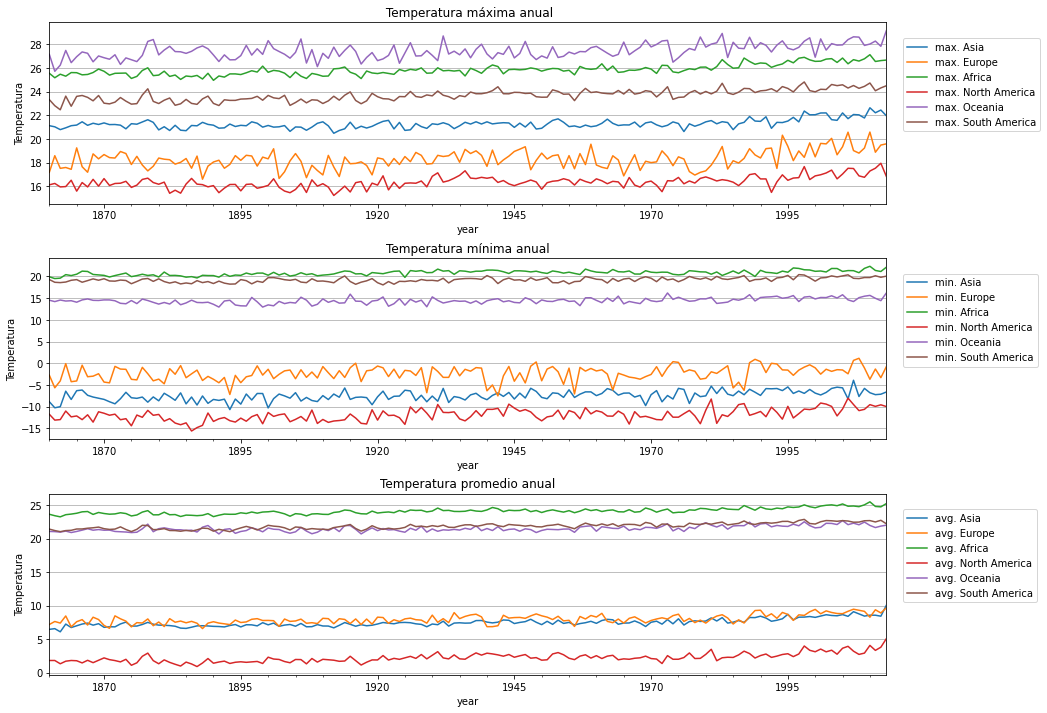

In [77]:
# Representación de la temperatura mínima, máxima y promedio por año para cada contienente

fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(15,12),sharex=False)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

a=["max.","min.","avg."]
b=[" Temperatura máxima anual", "Temperatura mínima anual","Temperatura promedio anual"]


for i in range(len(a)):
    
    data_sts[[str(a[i])+" Asia",str(a[i])+" Europe",str(a[i])+" Africa",
             str(a[i])+" North America",str(a[i])+" Oceania",str(a[i])+" South America"]].plot(ax=ax[i],title=b[i])
#     data_sts_mov_avg[[str(a[i])+" Asia",str(a[i])+" Europe",str(a[i])+" Africa",
#              str(a[i])+" North America",str(a[i])+" Oceania",str(a[i])+" South America"]].plot(ax=ax[i],title=b[i])
    ax[i].legend(loc=(1.02,0.4))
    ax[i].yaxis.grid()
    ax[i].set_ylabel('Temperatura')

#### Estudio de la estacionariedad -> forcasting

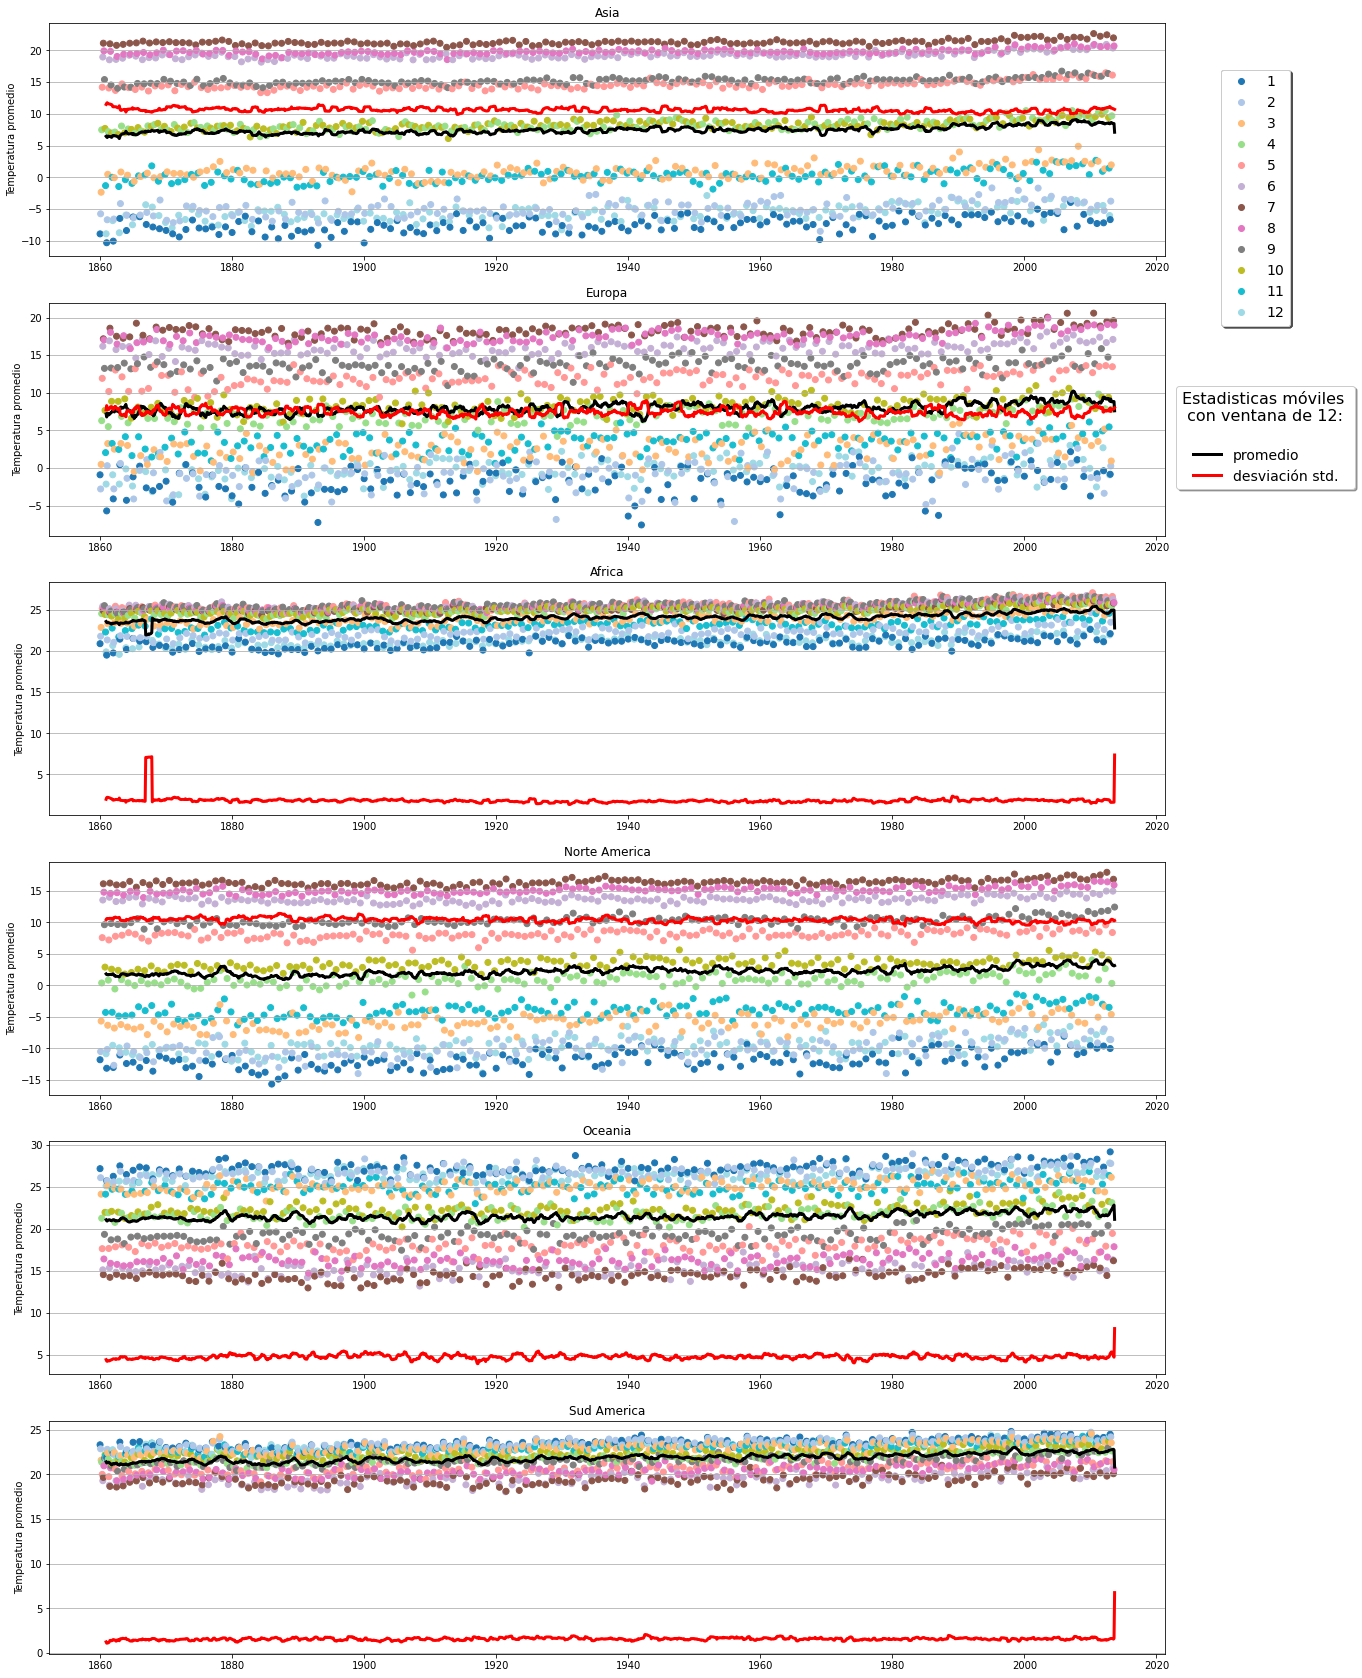

In [78]:
# Estudio de la estacionariedad con la estadistica móvil (promedio y desviación estandar)

fig, ax = plt.subplots(nrows=6, ncols=1,figsize=(20,30),sharex=False)

a=["Temp. Asia","Temp. Europe","Temp. Africa","Temp. North America","Temp. Oceania","Temp. South America"]
titulo=["Asia","Europa","Africa","Norte America","Oceania","Sud America"]
b=["Asia","Europe","Africa","North America","Oceania","South America"]

plot_lines = []

for i in range(len(a)):
    scatter=ax[i].scatter(data_month["fecha"][:],data_month[a[i]][:],c=data_month["month"][:]
                          ,cmap='tab20')
    plot1=ax[i].plot(data_mov_avg.index[:],data_mov_avg["Temp. "+str(b[i])][:],"-",label="promedio"
                     ,c="black",lw=3)
    plot1=ax[i].plot(data_mov_std.index[:],data_mov_std["Temp. "+str(b[i])][:],"-",label="desviación std."
                     ,c="red",lw=3)
    
    
    
    ax[i].set_title(titulo[i])
    ax[i].set_ylabel('Temperatura promedio')
    ax[i].yaxis.grid()
    
    
    legend1 = ax[0].legend(*scatter.legend_elements(),loc=(1.05,-0.30), fancybox=True, shadow=True,fontsize=14)
    ax[0].add_artist(legend1)
    
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels, loc=(1.01,-1),fontsize=14, fancybox=True, shadow=True)
    ax[0].get_legend().set_title("Estadisticas móviles \n con ventana de "+str(vent)+": \n",prop={'size':16})


In [79]:
def mean_var_sec(pais):
    X = data["Temp. "+str(pais)].dropna(axis=0)
    
    split = int(len(X) / 4)
    X1, X2,X3,X4 = X[0:split],X[split:split*2],X[split*2:split*3], X[split*3:]
    mean1,mean2,mean3,mean4 = X1.mean(), X2.mean(), X3.mean(), X4.mean()
    var1,var2,var3,var4 = X1.var(), X2.var(),X3.var(), X4.var()
    print('mean1={:.3f}, mean2={:.3f}, mean3={:.3f}, mean4={:.3f}'.format(mean1, mean2,mean3, mean4))
    print('variance1={:.3f}, variance2={:.3f}, variance3={:.3f}, variance4={:.3f}'.format(var1, var2,var3, var4))

In [80]:
b=["Asia","Europe","Africa","North America","Oceania","South America"]

for i in range(len(b)):
    print("\n-- " + str(b[i])+":")
    mean_var_sec(b[i])


-- Asia:
mean1=6.923, mean2=7.295, mean3=7.423, mean4=8.251
variance1=107.090, variance2=104.793, variance3=103.234, variance4=100.249

-- Europe:
mean1=7.475, mean2=7.883, mean3=7.973, mean4=8.607
variance1=53.587, variance2=49.714, variance3=52.649, variance4=50.958

-- Africa:
mean1=23.639, mean2=23.936, mean3=24.147, mean4=24.632
variance1=3.207, variance2=2.834, variance3=2.787, variance4=3.171

-- North America:
mean1=1.606, mean2=2.117, mean3=2.249, mean4=2.994
variance1=104.057, variance2=100.779, variance3=98.471, variance4=95.741

-- Oceania:
mean1=21.259, mean2=21.242, mean3=21.508, mean4=21.933
variance1=20.611, variance2=21.090, variance3=20.695, variance4=20.729

-- South America:
mean1=21.396, mean2=21.643, mean3=21.998, mean4=22.375
variance1=2.192, variance2=2.380, variance3=2.401, variance4=2.388


In [81]:
# Test de Dickey-Fuller

b=["Asia","Europe","Africa","North America","Oceania","South America"]

for i in range(len(b)):
    result = adfuller(data["Temp. "+ str(b[i])].dropna(axis=0))
    print("\n-- " + str(b[i])+":")
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])


-- Asia:
Test statistic:  -2.4073760328531515
p-value:  0.13966539137749084
Critical Values: {'1%': -3.4339481027788024, '5%': -2.8631293617920544, '10%': -2.5676161227508754}

-- Europe:
Test statistic:  -4.136609967191378
p-value:  0.0008420306838136832
Critical Values: {'1%': -3.4339500836471712, '5%': -2.8631302362582534, '10%': -2.567616588375528}

-- Africa:
Test statistic:  -2.604963223508559
p-value:  0.0919758028209659
Critical Values: {'1%': -3.4339540519343137, '5%': -2.863131988080628, '10%': -2.5676175211639354}

-- North America:
Test statistic:  -3.1621199513623774
p-value:  0.022284721101597516
Critical Values: {'1%': -3.4339481027788024, '5%': -2.8631293617920544, '10%': -2.5676161227508754}

-- Oceania:
Test statistic:  -4.209960679423135
p-value:  0.000633781010906399
Critical Values: {'1%': -3.4339520666978056, '5%': -2.8631311116872475, '10%': -2.567617054512932}

-- South America:
Test statistic:  -2.7727588312513727
p-value:  0.06227156607212094
Critical Values:

- <b>Asía</b>: La hipotesis nula no se puede rechazar (nivel de confianza para rechazar la hipotesis nula del 14%) -> serie temporal no estacionaria (hay estructura dependiente del tiempo).

- <b>Europa</b>: La hipotesis nula se puede recharar con un nivel de confianza del 1% -> serie temporal estacionaria (con bajo nivel de casualidad estadística).

- <b>África</b>: La hipotesis nula se puede recharar con un nivel de confianza del 10% -> un nivel de confianza muy alto, se debería suponer que la serie temporal es no estacionaria y hay una tendencia dependiente del tiempo. 

- <b>Norte América</b>: La hipotesis nula se puede recharar con un nivel de confianza del 3% -> serie temporal estacionaria (3%)

- <b>Oceania</b>: La hipotesis nula se puede recharar con un nivel de confianza del 1% -> serie temporal estacionaria.

- <b>Sud América</b>: La hipotesis nula se puede recharar con un nivel de confianza del 7% -> serie temporal estacionaria pero con nivel de confianza bajo. 


** Las únicas series temporales que parecen estacionarias con un nivel de confianza bajo som las temperaturas de Oceania y Europa. El resto tienen un nivel de confianza alto (especialmente Asía, África y Sud América). Aunque si observamos la media en las 4 regiones en las que lo hemos calculado vemos en que todos los contienentes la media aumenta con el tiempo. Así que parece que hay una tendendía a que la temperatura aumente con el tiempo en todos ellos, pero se mayor en algunos contienentes que en otros.